# Preliminaries

Dataset used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [9]:
import pandas as pd
import numpy as np
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
from pathlib import Path

random_seed = 131313 # for reproducibility
precomputed_rules_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_sex_atomic.data"
precomputed_rules_with_cumulative_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_sex_cumulative.data"

## Load Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 3.25 s
Wall time: 4.21 s


array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [6]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10205
           1       0.73      0.62      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.80      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



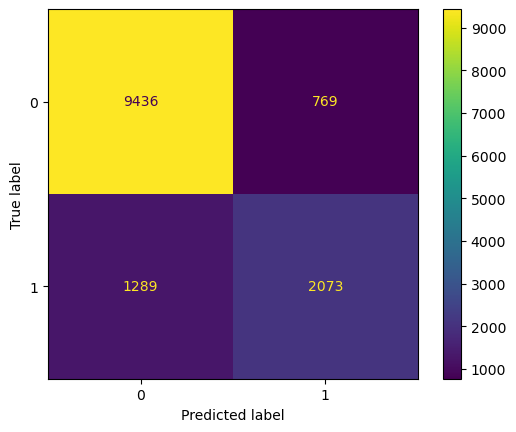

In [7]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and atomic correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
#Uncomment if you want to find new rules with different support

start_time = time.time()
ifthens_coverage_correctness, stats = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)
end_time = time.time()

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]

Number of frequent itemsets for affected: {' Female': 28176, ' Male': 27510}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████| 27510/27510 [00:00<00:00, 570175.64it/s]

Number of subgroups in the intersection: 13300


Number of frequent itemsets for the unaffected: 57008
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████████████████████████████████████████████████████████████████████| 13300/13300 [00:02<00:00, 5891.93it/s]


Computing correctenesses for all valid if-thens.


100%|████████████████████████████████████████████████████████████████████████████| 97413/97413 [20:30<00:00, 79.19it/s]


Number of if-thens: 97413


In [9]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if(precomputed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [12]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain", "capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

We continue with the rankings and selection of rules according to each of the proposed metrics.

In [14]:
stats["valid-if-thens-time"] = end_time - start_time
stats["triples-no"] = len(ifthens_coverage_correctness)
stats["subgroup-no"] = len(rules_by_if)

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [29]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, occupation =  Prof-specialty, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.34% covered out of 6546
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 57.95%.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 2.27% covered out of 4179
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relationship =  Married with effectiveness 53.68%.
		Aggregate cost of the above recourses = 14.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 4.0.
If Workclass =  Private, age = (34.0, 41.0], hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.16% covered out of 6546
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spous

### Equal Choice for Recourse

In [30]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Male', 11.47% covered out of 6546
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 35.95%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 33.02%.
		Make occupation =  Exec-managerial with effectiveness 21.97%.
		Make hours-per-week = OverTime, occupation =  Sales with effectiveness 21.97%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 36.22%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 43.68%.
		Make hours-per-week = BrainDrain, occupation =  Sales with effectiveness 21.97%.
		Make Workclass =  Local-gov, hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 22.37%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with effectiveness 33.42%.
		Make Workclass =  Self-emp-inc, hour

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [15]:
start_time = time.time()
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)
end_time = time.time()

100%|████████████████████████████████████████████████████████████████████████████| 12556/12556 [10:20<00:00, 20.24it/s]


In [16]:
stats["cumulative-time"] = end_time - start_time

In [23]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(precomputed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

NameError: name 'load_rules_by_if' is not defined

### Equal (Conditional) Mean Recourse

If hours-per-week = FullTime, marital-status =  Never-married, native-country =  United-States, race =  Black:
	Protected Subgroup ' Male', 2.20% covered out of 6546
		Make marital-status =  Married-civ-spouse with effectiveness 0.69% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 1.39% and counterfactual cost = 7.0.
		Make hours-per-week = OverTime, race =  White with effectiveness 1.39% and counterfactual cost = 102.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 1.39% and counterfactual cost = 105.0.
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.39% and counterfactual cost = 107.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.39% and counterfactual cost = 107.0.
		Make hours-per-week = PartTime, marital-status =  Married-civ-spouse, race =  White with effect

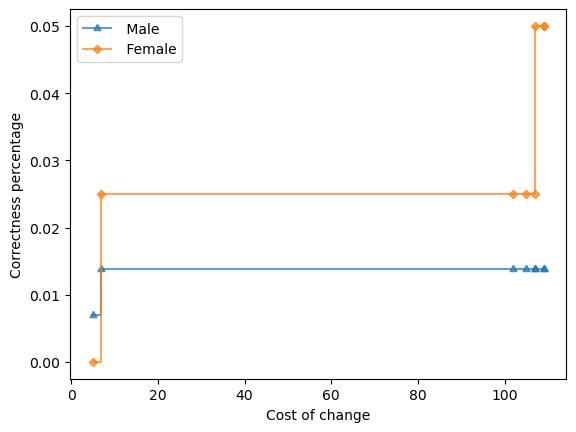

If race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.73% covered out of 6546
		Make relationship =  Married with effectiveness 1.12% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 1.12% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 1.68% and counterfactual cost = 105.0.
		Make race =  White, relationship =  Married with effectiveness 3.35% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 71.67
	Protected Subgroup ' Female', 3.88% covered out of 4179
		Make relationship =  Married with effectiveness 2.47% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.47% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.47% and counterfactual cost = 105.0.
		Make race =  White, relationship =  Married with effectiveness 3.09% and counterfactual cost = 105.0.
		Aggregate cost 

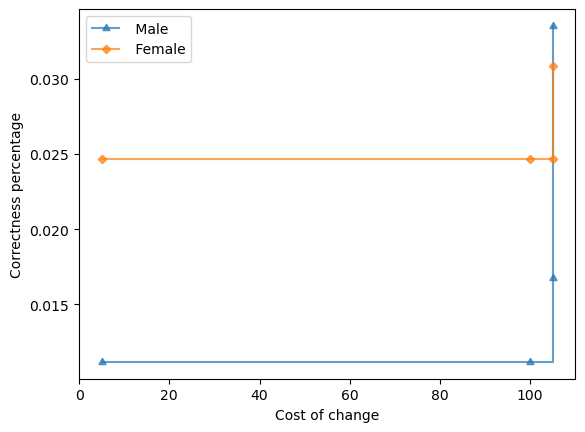

If capital-loss = 0, occupation =  Other-service, race =  Black:
	Protected Subgroup ' Male', 1.41% covered out of 6546
		Make occupation =  Exec-managerial with effectiveness 1.09% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Transport-moving, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Sales, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Adm-clerical, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Tech-support, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Protective-serv, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty,

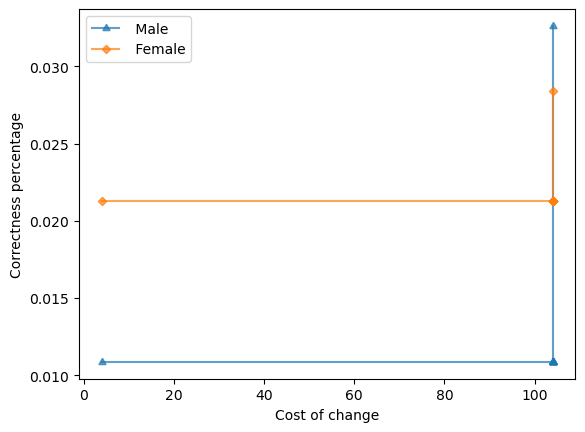

If marital-status =  Never-married, race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.63% covered out of 6546
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 2.80% and counterfactual cost = 10.0.
		Make race =  White, relationship =  Not-in-family with effectiveness 2.80% and counterfactual cost = 105.0.
		Make marital-status =  Divorced, race =  White, relationship =  Not-in-family with effectiveness 2.80% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.80% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 4.67% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 50.00
	Protected Subgroup ' Female', 1.87% covered out of 4179
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 3.8

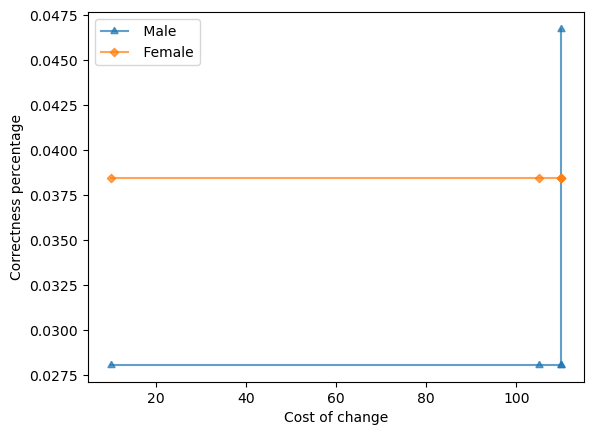

If Workclass =  Private, native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.88% covered out of 6546
		Make relationship =  Married with effectiveness 0.81% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 0.81% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 2.44% and counterfactual cost = 105.0.
		Make Workclass =  Self-emp-not-inc, race =  White, relationship =  Married with effectiveness 2.44% and counterfactual cost = 107.0.
		Make Workclass =  Local-gov, race =  White, relationship =  Married with effectiveness 2.44% and counterfactual cost = 107.0.
		Make Workclass =  State-gov, race =  White, relationship =  Married with effectiveness 2.44% and counterfactual cost = 107.0.
		Make Workclass =  Self-emp-inc, race =  White, relationship =  Married with effectiveness 2.44% and counterfactual cost = 107.0.
		Make Workclass =  Federal-gov, race =  White, r

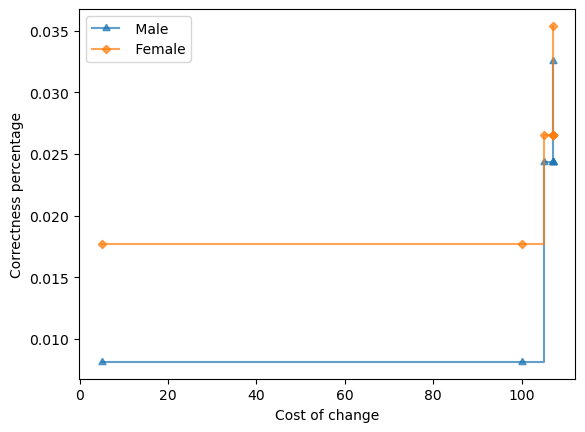

In [31]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Exec-managerial:
	Protected Subgroup ' Male', 1.02% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 38.81% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 38.81% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 65.67% and counterfactual cost = 5.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Sales with effectiveness 65.67% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.66
	Protected Subgroup ' Female', 1.46% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 3.28% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 3.28% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime wi

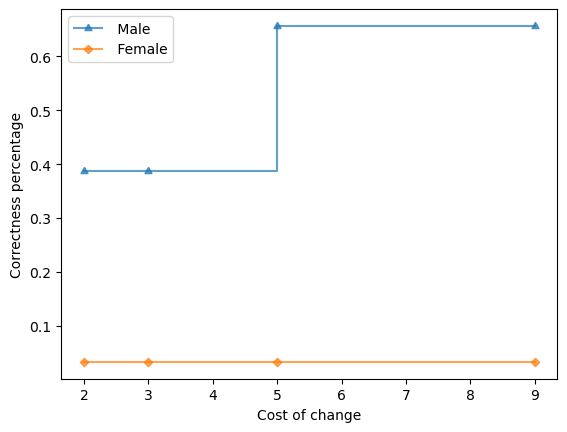

If capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.25% covered (protected subgroup population size not given)
		Make education-num = 10, hours-per-week = OverTime with effectiveness 35.37% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 35.37% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 35.37% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 52.44% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.52
	Protected Subgroup ' Female', 1.10% covered (protected subgroup population size not given)
		Make education-num = 10, hours-per-week = OverTime with effectiveness 6.52% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occ

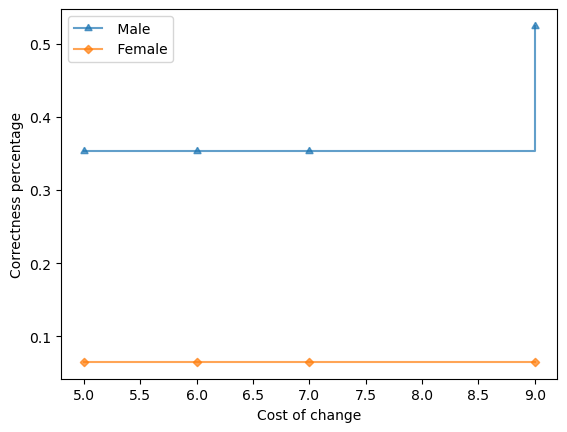

If Workclass =  Private, capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Male', 2.29% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 40.00% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 54.00% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.17% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.08
	Bias against  Female due to Equ

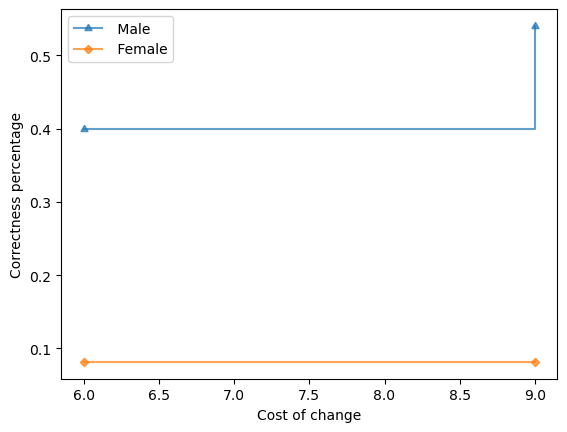

If education-num = 10, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.01% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 30.30% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 30.30% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 50.00% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 50.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup ' Female', 1.10% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 4.35% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 4.35% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-mana

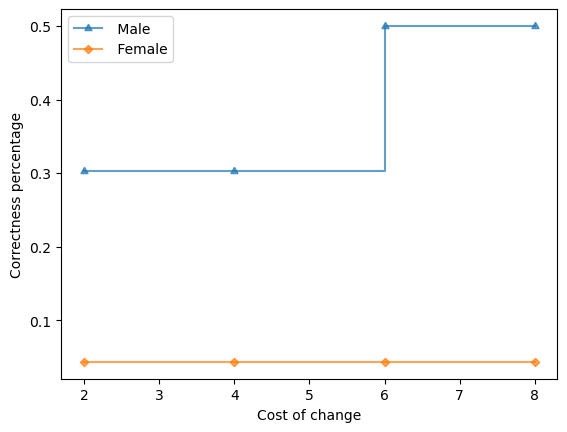

If capital-loss = 0, education-num = 10, hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Male', 1.02% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 29.85% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 29.85% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 49.25% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 49.25% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.49
	Protected Subgroup ' Female', 1.12% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 4.26% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 4.26% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with eff

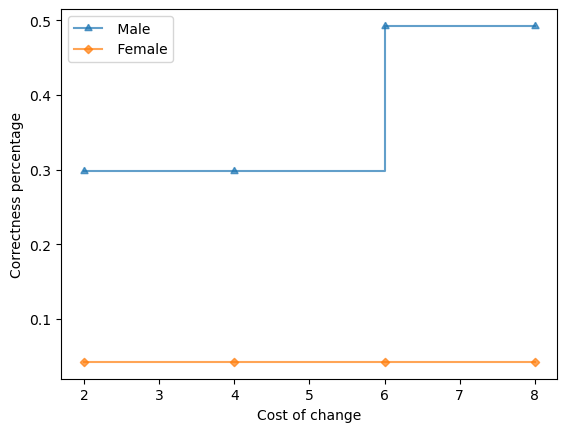

If Workclass =  Private, age = (41.0, 50.0], occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.45% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0], occupation =  Craft-repair with effectiveness 8.42% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 12.63% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 24.21% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 29.47% and counterfactual cost = 14.0.
		Make Workclass =  Self-emp-not-inc, age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 29.47% and counterfactual cost = 16.0.
		Make Workclass =  Local-gov, age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 29.47% and counterfactual cost = 16.0.
		Make Workclass =  Self-emp-inc, age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 4

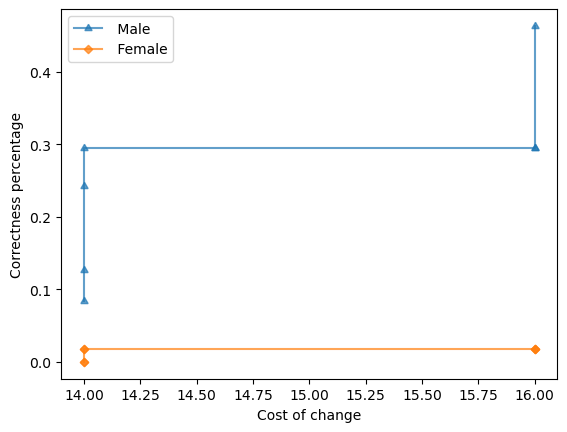

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 2.66% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 1.72% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 16.09% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], education-num = 12 with effectiveness 48.85% and counterfactual cost = 16.0.
		Aggregate cost of the above recourses = 0.49
	Protected Subgroup ' Female', 2.56% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 3.74% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], education-num = 12 with effectiveness 5.61% and counterfactual cost = 16.0.
		Aggregate cost of the above recourses = 0.06
	Bias against  Female due to Equal Effectiveness. Unfairn

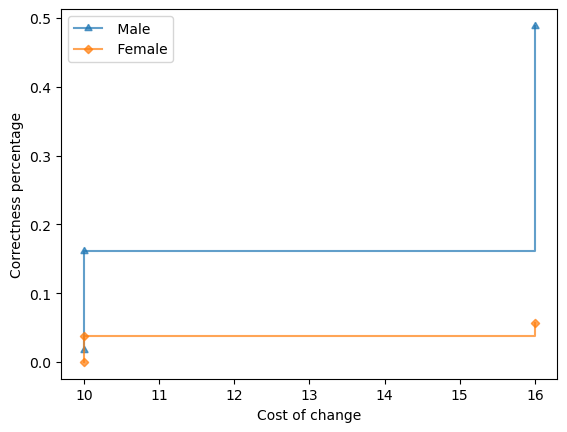

If Workclass =  Private, age = (34.0, 41.0], capital-gain = 0, occupation =  Sales:
	Protected Subgroup ' Male', 1.02% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 2.99% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 20.90% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 20.90% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 20.90% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 29.85% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 29.85% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 43.28% and counterfactual cost = 14.0.
		Make Workclass =  Local-gov, age = (41.0, 50.0], occupation =  Prof-specialty with effe

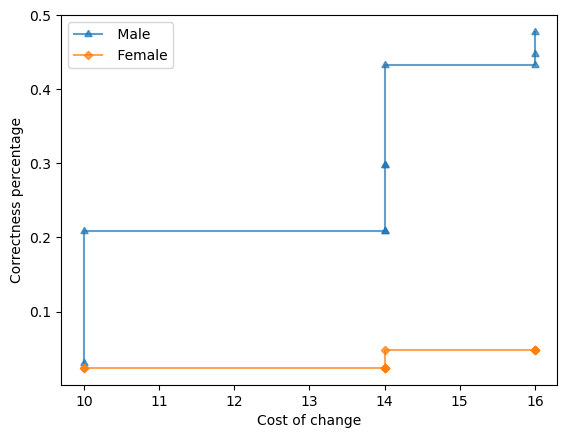

If Workclass =  Private, capital-loss = 0, education-num = 11, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 1.37% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 33.33% and counterfactual cost = 2.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 36.67% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiveness 36.67% and counterfactual cost = 6.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 44.44% and counterfactual cost = 8.0.
		Make education-num = 13, hours-per-week = BrainDrain with effectiveness 44.44% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-inc, education-num = 13, hours-per-week = OverTime with effectiveness 44.44% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 1.56% covered (protected subgroup population size 

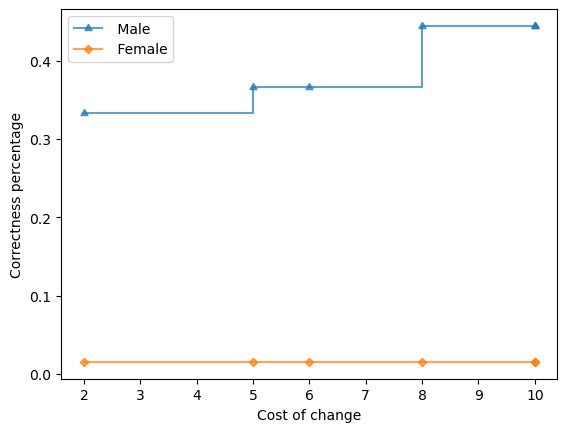

If Workclass =  Private, age = (26.0, 34.0], capital-loss = 0, native-country =  United-States, occupation =  Exec-managerial:
	Protected Subgroup ' Male', 1.10% covered (protected subgroup population size not given)
		Make age = (34.0, 41.0] with effectiveness 31.94% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 44.44% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0] with effectiveness 47.22% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], occupation =  Sales with effectiveness 47.22% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Craft-repair with effectiveness 47.22% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], occupation =  Craft-repair with effectiveness 47.22% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 47.22% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Sales with effective

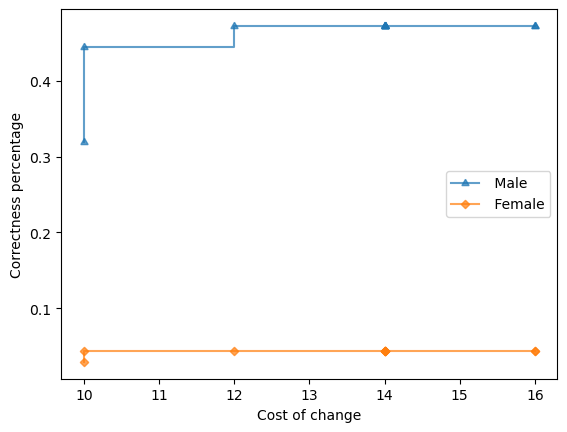

In [32]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If capital-gain = 0, education-num = 11, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 1.92% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 30.95% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup ' Female', 2.01% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 2.38% and counterfactual cost = 2.0.
		Make education-num = 12 with effectiveness 2.38% and counterfactual cost = 3.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 3.57% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiveness 3.57% and counterfactual cost = 6.0.
		Make education-num = 13, hours-per-week = MidTime with effectiveness 3.57% and counterfactual cost = 8.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 3.57% and counterfactual cost = 8.0.
		Make capital-gain

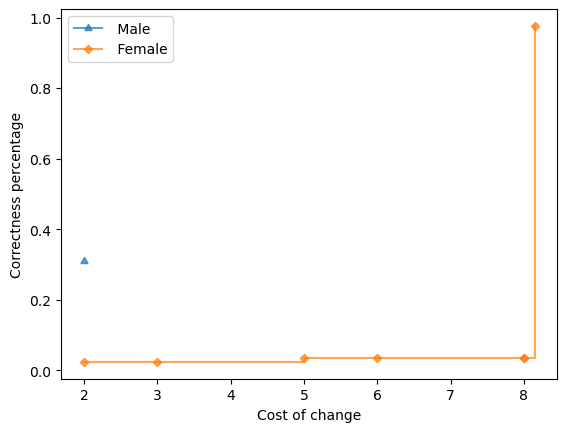

If Workclass =  Private, capital-loss = 0, marital-status =  Never-married, occupation =  Sales, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.62% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.08% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 1.94% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 11.11% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 11.11% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 18.52% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving,

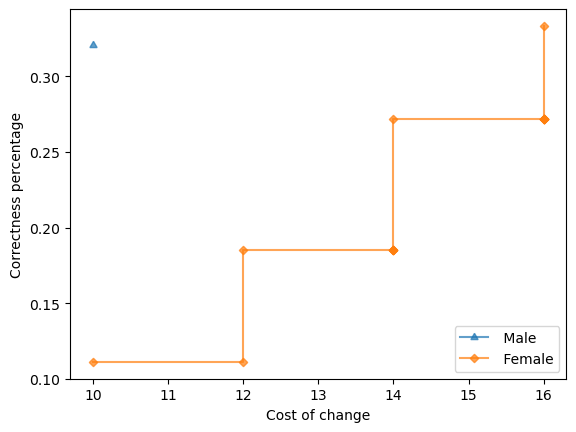

If education-num = 13, marital-status =  Divorced:
	Protected Subgroup ' Male', 1.37% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 38.89% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup ' Female', 2.63% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 20.00% and counterfactual cost = 5.0.
		Make education-num = 14, marital-status =  Married-civ-spouse with effectiveness 27.27% and counterfactual cost = 8.0.
		Make education-num = 15, marital-status =  Married-civ-spouse with effectiveness 43.64% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 6.0.
	Cumulative effectiveness plot for the above recourses:


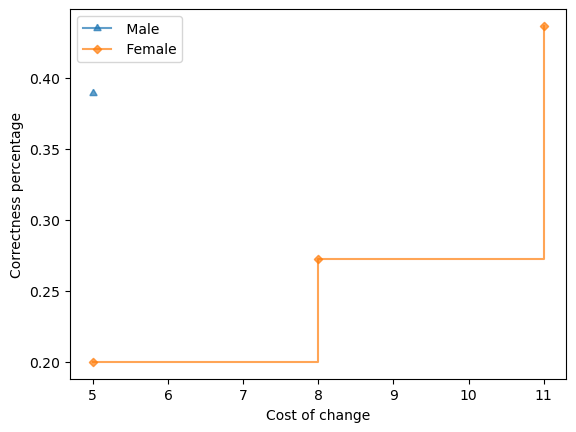

If capital-loss = 0, marital-status =  Never-married, occupation =  Sales, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.91% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 31.20% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 2.06% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 10.47% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving, relationship =  Married with effectiveness 10.47% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 10.47% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married

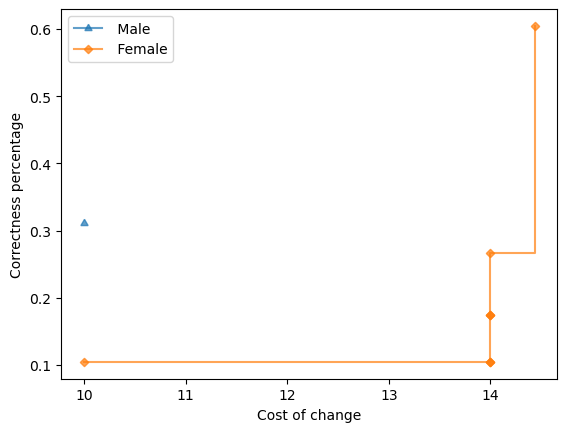

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, occupation =  Sales, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.73% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 30.97% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 1.75% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 10.96% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 10.96% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married with effectiveness 10.96% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Prof-spe

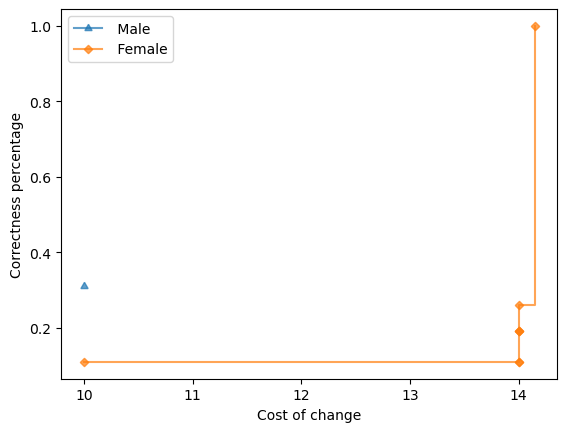

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married, occupation =  Sales, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.57% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 31.07% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 1.94% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 11.11% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 18.52% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 18.52% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Ad

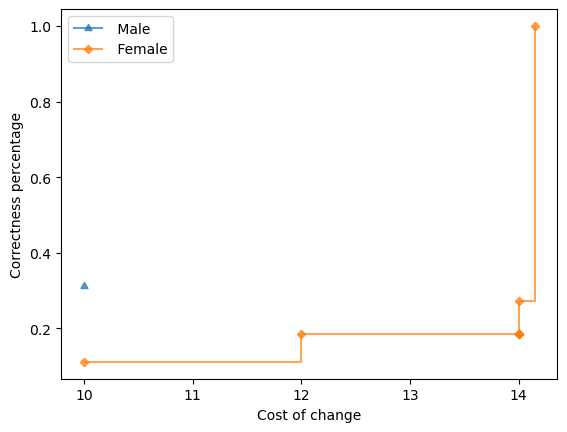

If Workclass =  Private, marital-status =  Never-married, occupation =  Prof-specialty:
	Protected Subgroup ' Male', 2.18% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 19.58% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse with effectiveness 19.58% and counterfactual cost = 7.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse with effectiveness 19.58% and counterfactual cost = 7.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse with effectiveness 19.58% and counterfactual cost = 7.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse with effectiveness 23.78% and counterfactual cost = 7.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse with effectiveness 33.57% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 7.00
	Protected Subgroup ' Female', 3.85% 

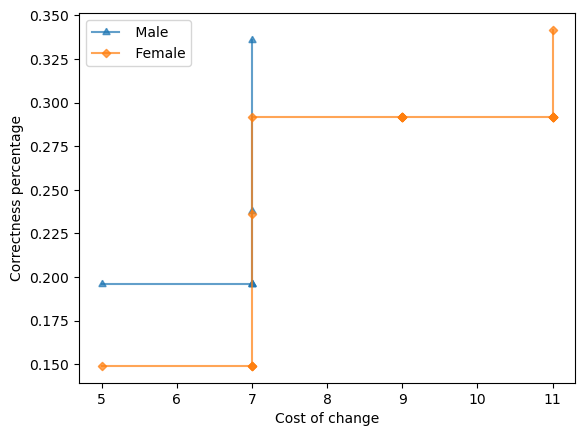

If marital-status =  Never-married, occupation =  Sales, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.02% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.58% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 2.27% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 16.84% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving, relationship =  Married with effectiveness 16.84% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 16.84% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married with effectivenes

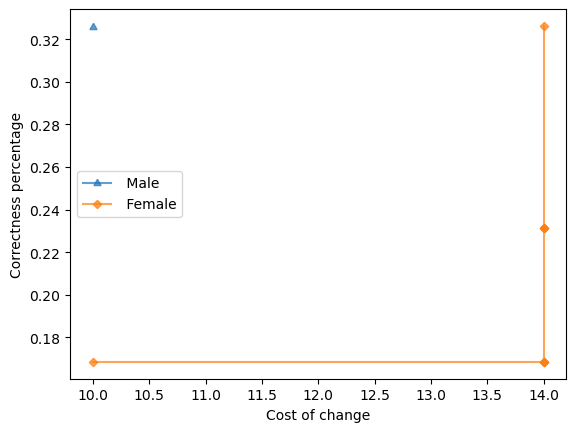

If Workclass =  Private, hours-per-week = MidTime, marital-status =  Married-civ-spouse, native-country =  United-States:
	Protected Subgroup ' Male', 1.96% covered (protected subgroup population size not given)
		Make hours-per-week = FullTime with effectiveness 6.25% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = FullTime with effectiveness 6.25% and counterfactual cost = 4.0.
		Make Workclass =  State-gov, hours-per-week = FullTime with effectiveness 6.25% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, hours-per-week = FullTime with effectiveness 6.25% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, hours-per-week = FullTime with effectiveness 16.41% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime with effectiveness 22.66% and counterfactual cost = 4.0.
		Make Workclass =  Federal-gov, hours-per-week = FullTime with effectiveness 24.22% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-n

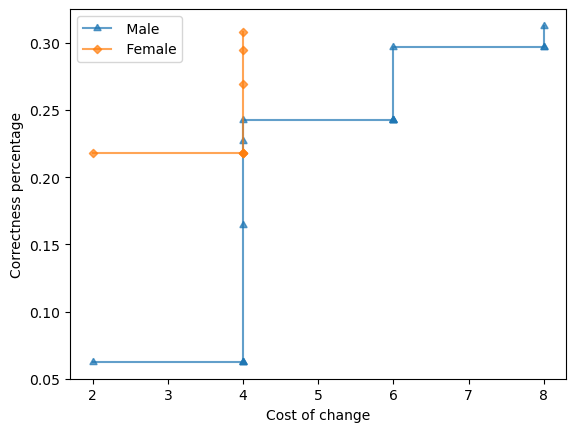

If marital-status =  Never-married, occupation =  Sales, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.86% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.79% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 1.91% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 16.25% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving, relationship =  Married with effectiveness 16.25% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 16.25% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married wi

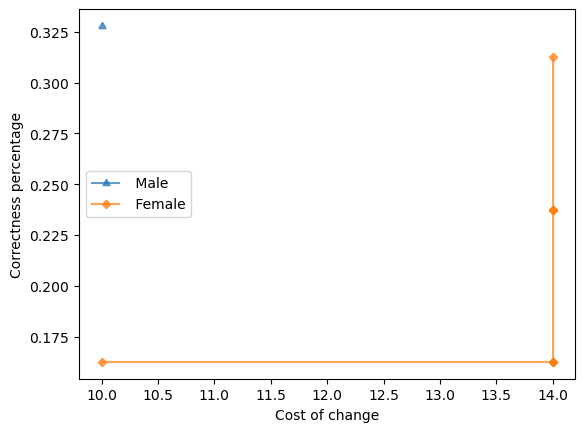

If Workclass =  Private, capital-loss = 0, hours-per-week = PartTime, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Male', 1.53% covered (protected subgroup population size not given)
		Make hours-per-week = MidTime with effectiveness 15.00% and counterfactual cost = 2.0.
		Make hours-per-week = FullTime with effectiveness 24.00% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = FullTime with effectiveness 24.00% and counterfactual cost = 6.0.
		Make Workclass =  State-gov, hours-per-week = FullTime with effectiveness 24.00% and counterfactual cost = 6.0.
		Make Workclass =  Local-gov, hours-per-week = FullTime with effectiveness 24.00% and counterfactual cost = 6.0.
		Make Workclass =  Self-emp-inc, hours-per-week = FullTime with effectiveness 33.00% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 6.00
	Protected Subgroup ' Female', 1.39% covered (protected subgroup population size not given)
		Make hours-per-w

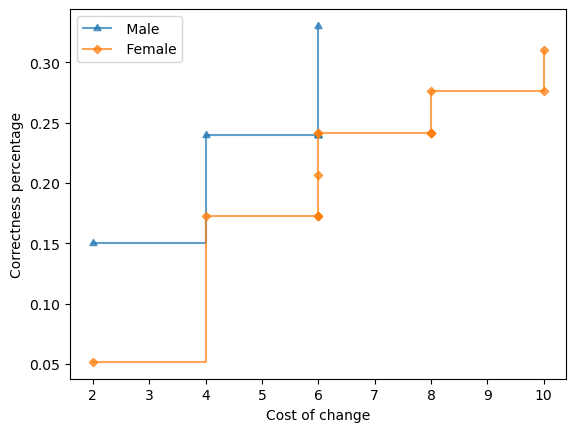

If Workclass =  Private, capital-loss = 0, hours-per-week = PartTime, relationship =  Married:
	Protected Subgroup ' Male', 1.47% covered (protected subgroup population size not given)
		Make hours-per-week = MidTime with effectiveness 15.62% and counterfactual cost = 2.0.
		Make hours-per-week = FullTime with effectiveness 25.00% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = FullTime with effectiveness 25.00% and counterfactual cost = 6.0.
		Make Workclass =  State-gov, hours-per-week = FullTime with effectiveness 25.00% and counterfactual cost = 6.0.
		Make Workclass =  Local-gov, hours-per-week = FullTime with effectiveness 25.00% and counterfactual cost = 6.0.
		Make Workclass =  Self-emp-inc, hours-per-week = FullTime with effectiveness 34.38% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 6.00
	Protected Subgroup ' Female', 1.22% covered (protected subgroup population size not given)
		Make hours-per-week = MidTime

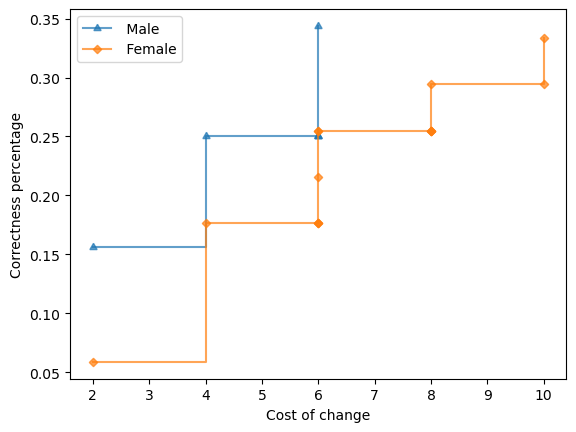

If Workclass =  Private, marital-status =  Never-married, occupation =  Adm-clerical, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.13% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 20.27% and counterfactual cost = 10.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.43% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Protected Subgroup ' Female', 3.88% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 9.88% and counterfactual cost = 10.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 23.46% and counterfactual cost = 12.0.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving, relationship =  M

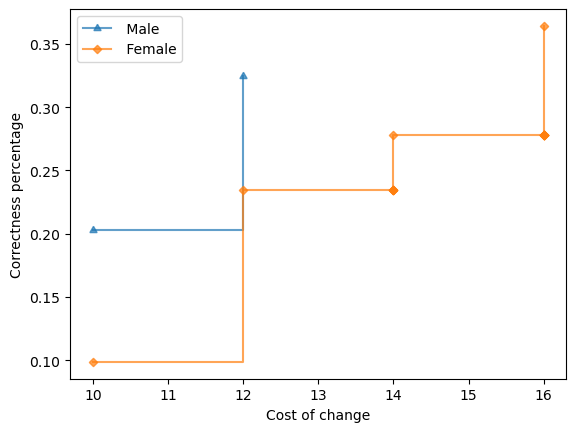

If education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, race =  White:
	Protected Subgroup ' Male', 11.12% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 12.77% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 12.77% and counterfactual cost = 3.0.
		Make hours-per-week = BrainDrain with effectiveness 13.32% and counterfactual cost = 4.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 30.49% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup ' Female', 1.99% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 13.25% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 13.25% and counterfactual cost = 3.0.
		Make hours-per-week = BrainDrain with effectiveness 16.87% and counterfactual cost = 4.0.
		Make education-num = 10, h

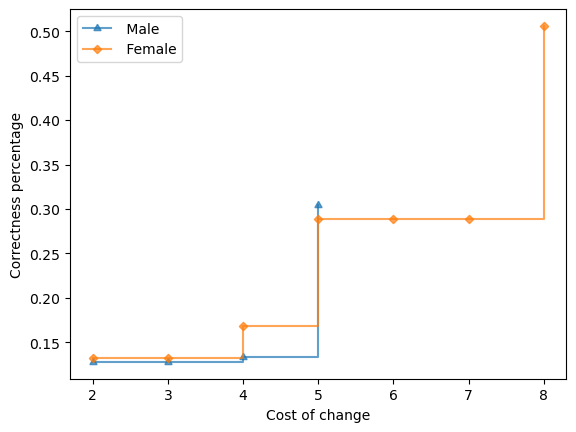

In [33]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Exec-managerial:
	Protected Subgroup ' Male', 1.02% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 38.81% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 38.81% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 65.67% and counterfactual cost = 5.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Sales with effectiveness 65.67% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.66
	Protected Subgroup ' Female', 1.46% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 3.28% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 3.28% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime wi

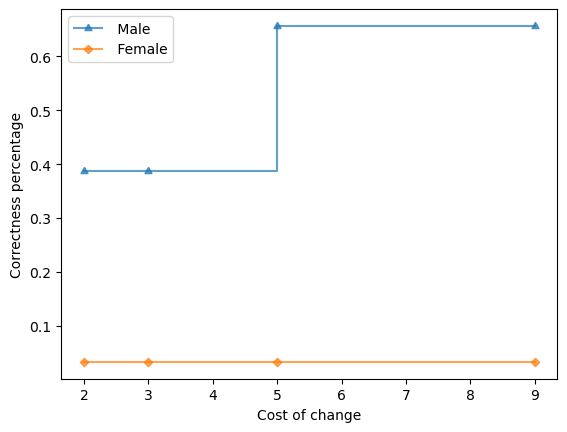

If capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.25% covered (protected subgroup population size not given)
		Make education-num = 10, hours-per-week = OverTime with effectiveness 35.37% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 35.37% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 35.37% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 52.44% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.52
	Protected Subgroup ' Female', 1.10% covered (protected subgroup population size not given)
		Make education-num = 10, hours-per-week = OverTime with effectiveness 6.52% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occ

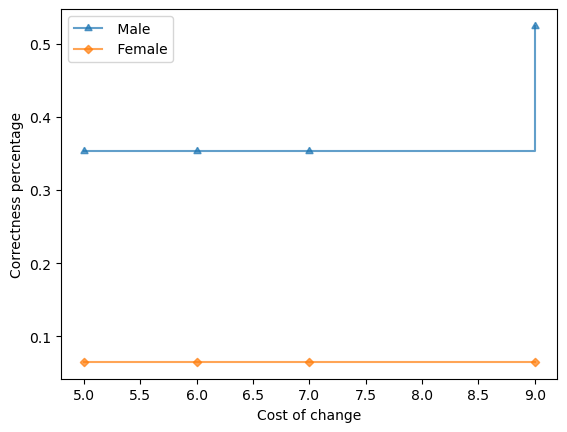

If Workclass =  Private, capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Male', 2.29% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 40.00% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 54.00% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.17% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.08
	Bias against  Female due to Equ

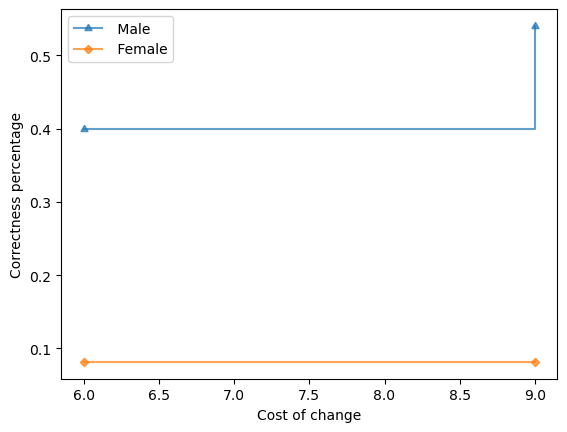

If education-num = 10, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.01% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 30.30% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 30.30% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 50.00% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 50.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup ' Female', 1.10% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 4.35% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 4.35% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-mana

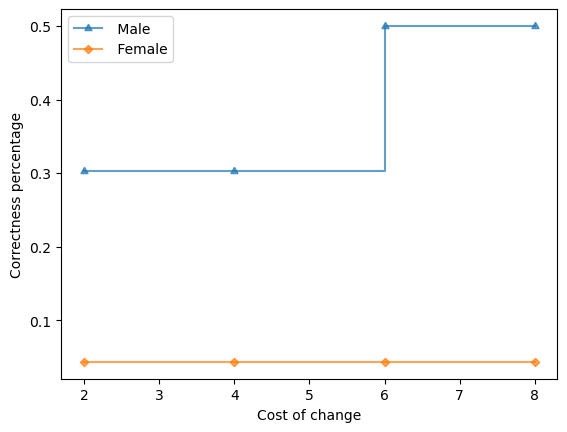

If capital-loss = 0, education-num = 10, hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Male', 1.02% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 29.85% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 29.85% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 49.25% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 49.25% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.49
	Protected Subgroup ' Female', 1.12% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 4.26% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 4.26% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with eff

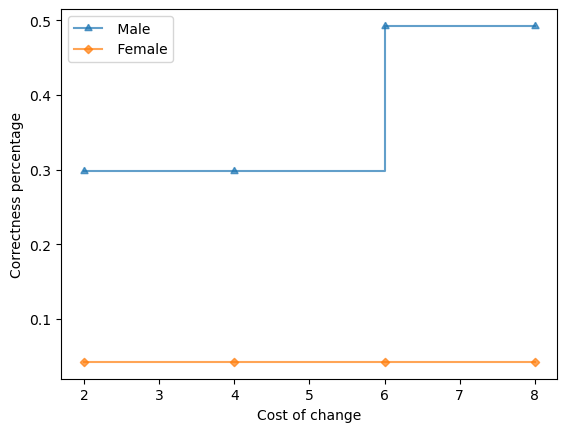

If Workclass =  Private, capital-loss = 0, education-num = 11, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 1.37% covered (protected subgroup population size not given)
		Make hours-per-week = OverTime with effectiveness 33.33% and counterfactual cost = 2.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 36.67% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiveness 36.67% and counterfactual cost = 6.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 44.44% and counterfactual cost = 8.0.
		Make education-num = 13, hours-per-week = BrainDrain with effectiveness 44.44% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-inc, education-num = 13, hours-per-week = OverTime with effectiveness 44.44% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.44
	Protected Subgroup ' Female', 1.56% covered (protected subgroup population size 

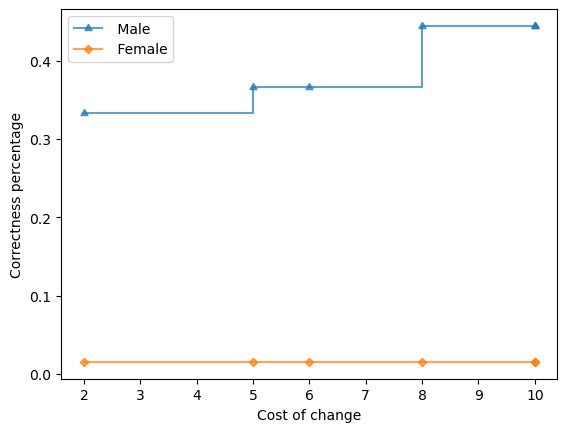

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, occupation =  Exec-managerial:
	Protected Subgroup ' Male', 1.15% covered (protected subgroup population size not given)
		Make age = (34.0, 41.0] with effectiveness 34.67% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 48.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.48
	Protected Subgroup ' Female', 1.72% covered (protected subgroup population size not given)
		Make age = (34.0, 41.0] with effectiveness 4.17% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 5.56% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.06
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.424.
	Cumulative effectiveness plot for the above recourses:


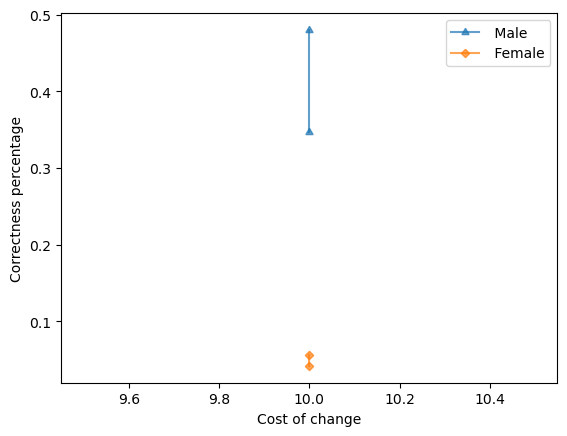

In [34]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 93.81% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 25.06% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 33.33% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 38.53% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 49.99% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 52.13% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.07% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 82.07% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 82.07% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 82.07% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgrou

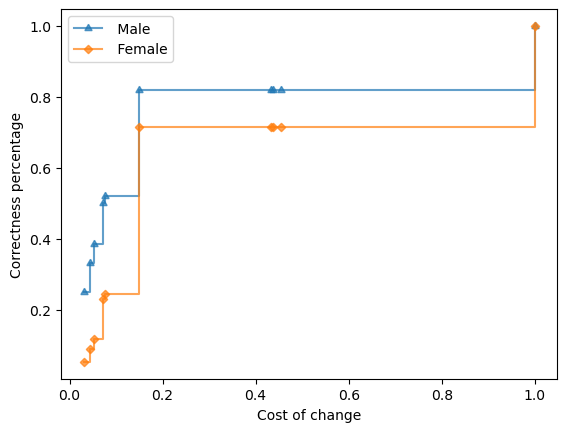

If capital-gain = 0:
	Protected Subgroup ' Male', 96.53% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 25.45% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 33.90% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 39.15% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 50.59% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 52.70% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.42% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 96.48% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 5.75% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 9.55% and counterfactual cost = 0.04.
		Make capital-gain = 5178 wit

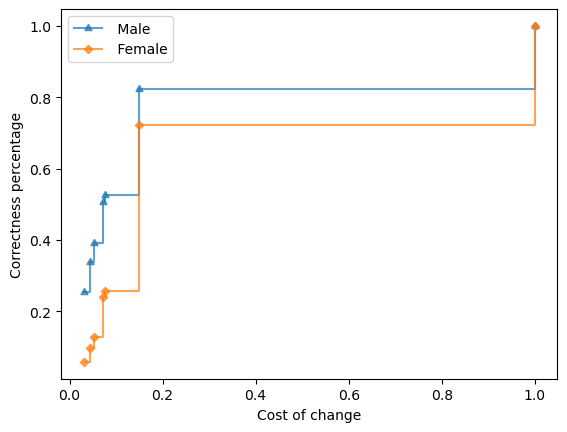

If capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 84.36% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 26.39% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 34.84% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 40.29% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 51.79% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.98% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.21% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 83.21% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 83.21% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 83.21% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactu

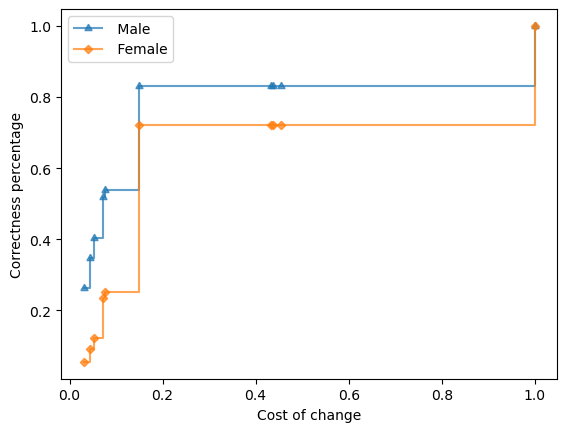

If capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 86.95% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 26.77% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 35.40% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 40.92% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 52.37% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.53% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.56% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 87.58% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 5.96% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 9.92% and counterfactual cost = 0.0

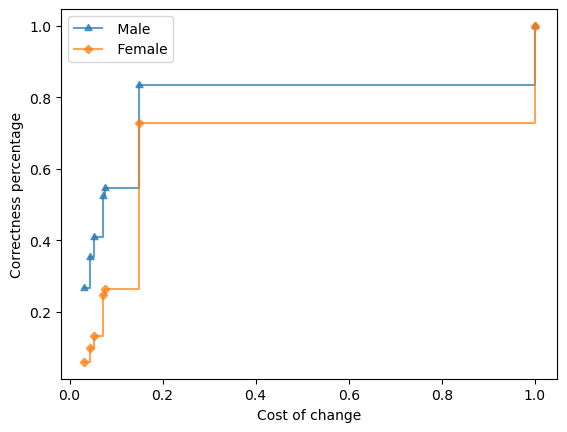

If capital-gain = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 76.81% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 28.20% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 37.25% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 42.84% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 54.24% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 56.46% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.39% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Black with effectiveness 100.00% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 71.43% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 6.57% and counterfactua

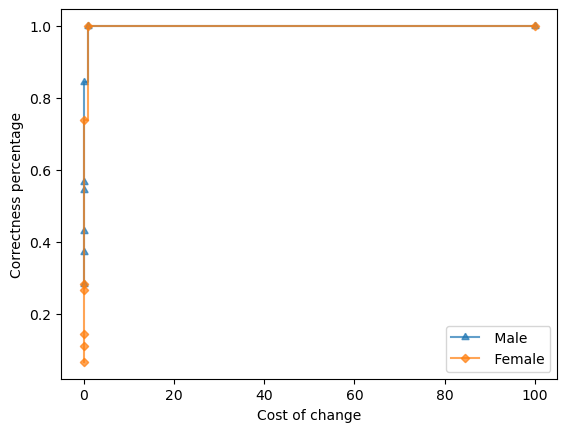

If capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 74.53% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 27.83% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 36.71% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 42.24% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 53.66% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.91% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.05% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 84.05% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 84.05% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 84.05% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% a

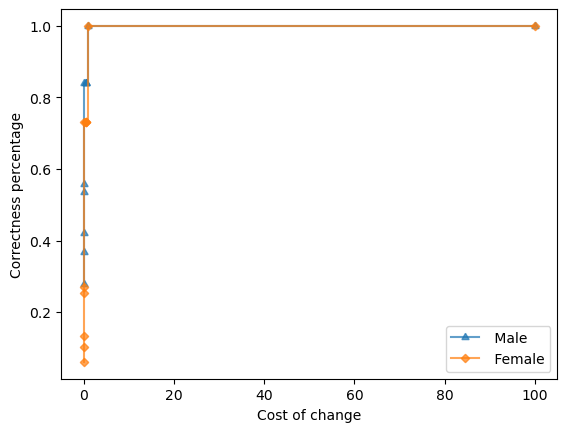

If capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 81.03% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 26.58% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 35.18% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 40.52% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 51.81% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.00% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.86% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 82.86% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 82.86% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 82.86% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		M

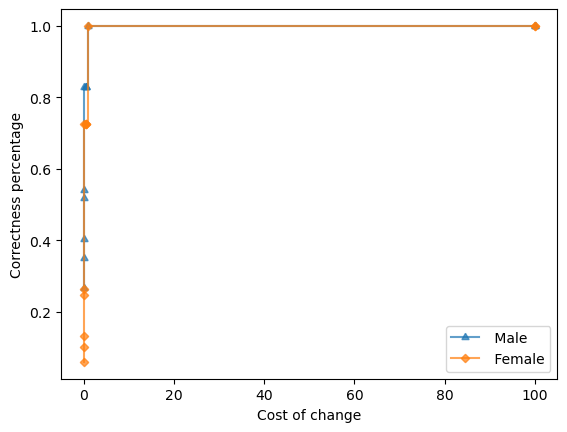

If capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 83.36% covered (protected subgroup population size not given)
		Make capital-gain = 3103 with effectiveness 26.96% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 35.73% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 41.12% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 52.39% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.55% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.20% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Asian-Pac-Islander with effectiveness 100.00% and counterfactual cost = 100.0.
		Make race =  Black with effectiveness 100.00% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 76.88% covered (protected subgroup population size not given)
		Make c

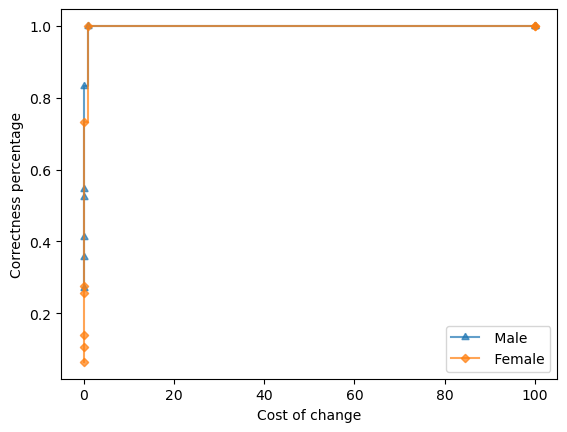

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 63.47% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 48.11% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 50.25% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.51% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 80.51% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 80.51% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 80.51% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with 

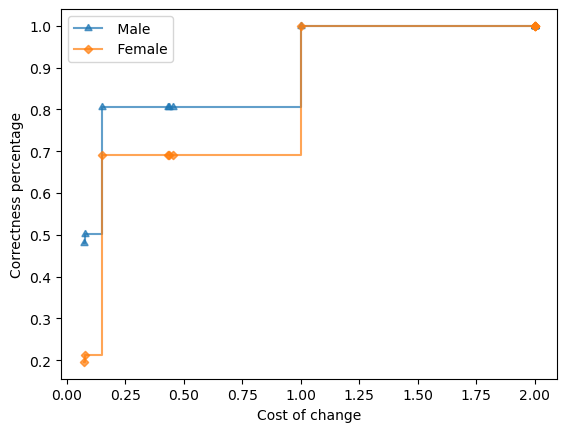

If Workclass =  Private, capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 71.59% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 45.97% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 48.06% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 79.11% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 79.11% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 79.11% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 79.11% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counter

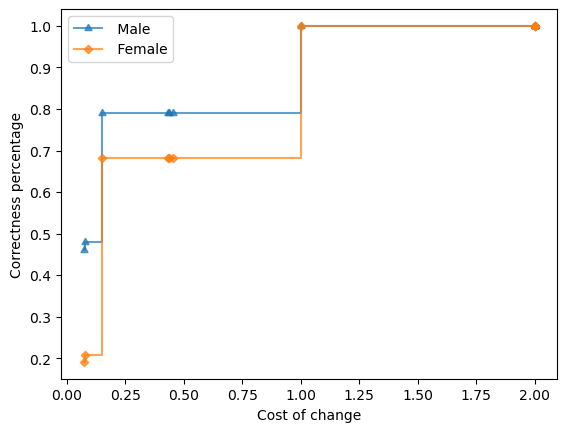

If Workclass =  Private, capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 65.41% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 48.72% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 50.82% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.90% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 68.99% c

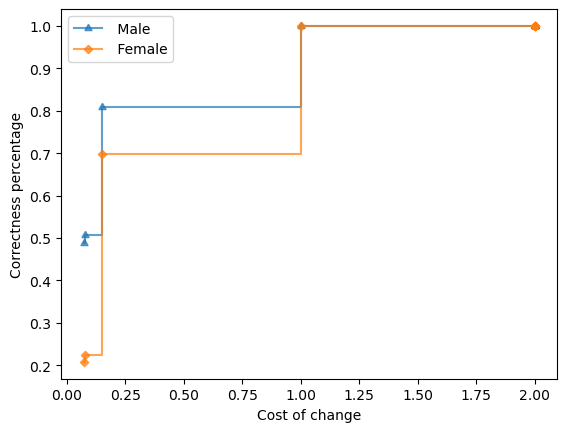

If Workclass =  Private, capital-gain = 0:
	Protected Subgroup ' Male', 73.60% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 46.58% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 48.63% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 79.49% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 76.29% covered (protected subgroup popula

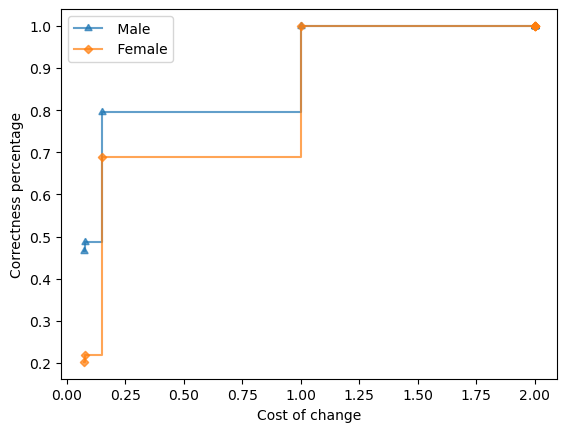

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 56.06% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 49.92% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 52.15% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.39% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 81.39% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 81.39% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 81.39% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  

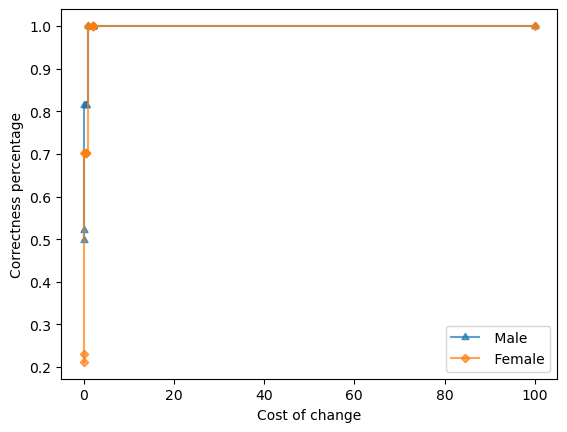

If Workclass =  Private, capital-gain = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 57.73% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 50.49% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 52.69% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.77% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make race =  Black wit

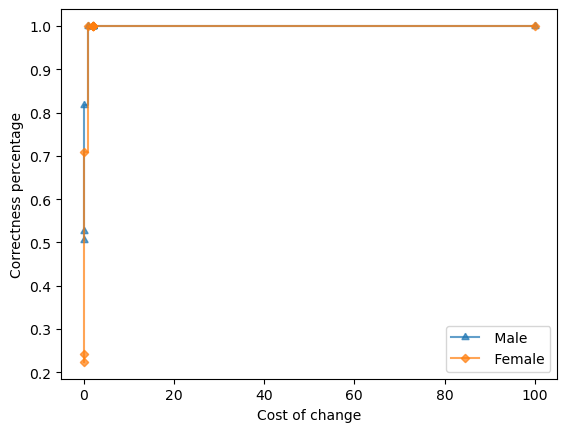

If capital-loss = 0:
	Protected Subgroup ' Male', 97.28% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 28.41% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 28.80% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 29.82% and counterfactual cost = 0.45.
	Protected Subgroup ' Female', 97.06% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 7.59% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 7.62% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 8.14% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.79.
	Cumulative effectiveness plot for the above recourses:


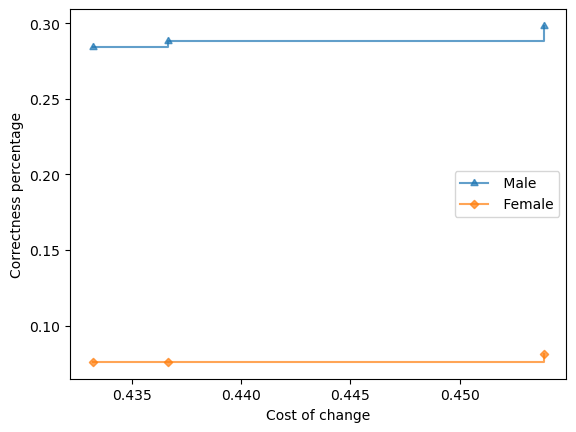

If capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 87.41% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.80% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 30.23% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 31.23% and counterfactual cost = 0.45.
	Protected Subgroup ' Female', 88.27% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 7.86% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 7.89% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 8.46% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.79.
	Cumulative effectiveness plot for the above recourses:


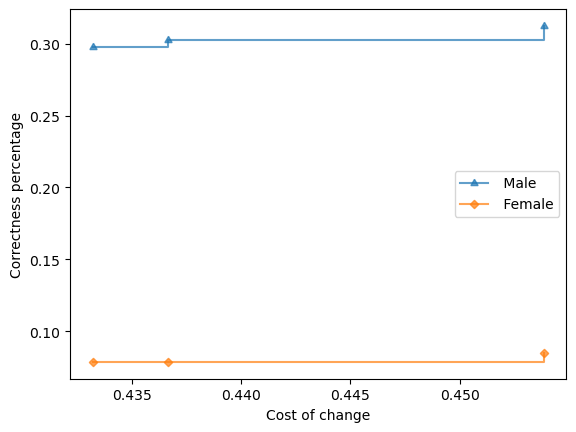

If Workclass =  Private, capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 61.64% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 47.68% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 49.86% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 79.93% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 79.93% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 79.93% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 79.93% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.

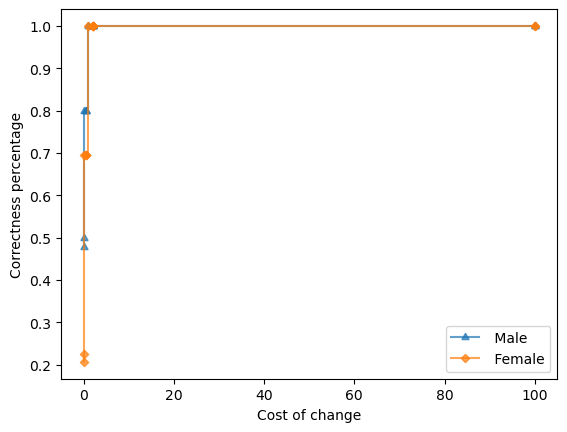

If Workclass =  Private, capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 63.34% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 48.24% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 50.39% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.29% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make race =  Asian-Pac-Islander with effectiveness 100.

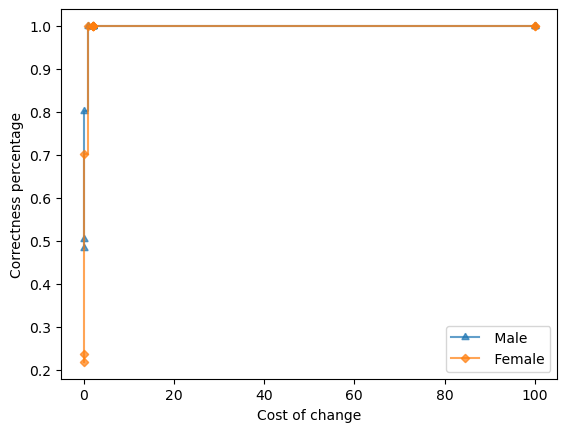

If capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 77.24% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 31.31% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 31.78% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 32.79% and counterfactual cost = 0.45.
		Make race =  Black with effectiveness 32.79% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 71.72% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 8.68% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 8.71% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 9.34% and counterfactual cost = 0.45.
		Make race =  Black with effectiveness 9.34% and counterfactual cost = 100.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.17.
	Cumulative 

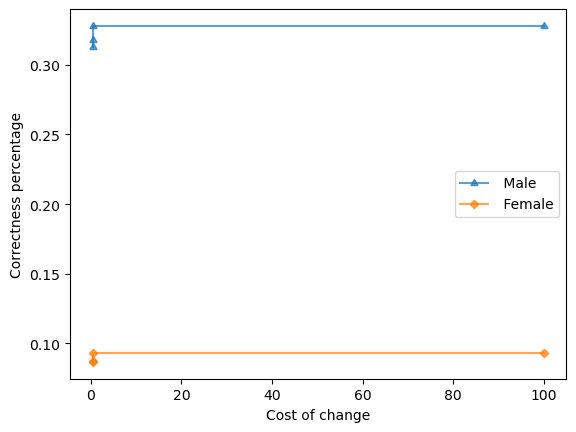

If capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 84.01% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.99% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 30.42% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 31.44% and counterfactual cost = 0.45.
		Make race =  Black with effectiveness 31.44% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 31.44% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 77.08% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 8.44% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 8.48% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 9.07% and counterfactual cost = 0.45.
		Make race =  Black with effectiveness 9.07% and counterfactual cost = 100.0.
		Make race =  Asian-

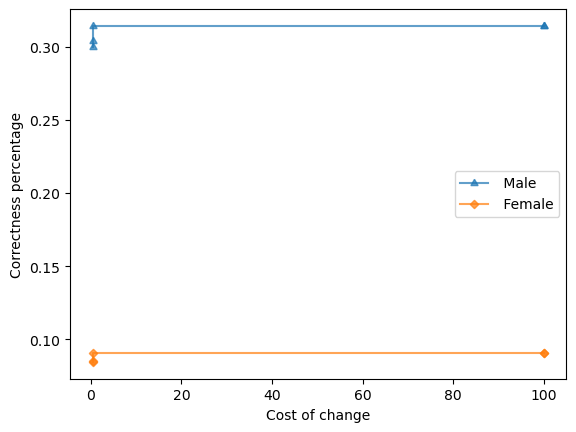

If Workclass =  Private, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 65.66% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 27.76% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 28.15% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 28.92% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 28.92% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 69.63% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effect

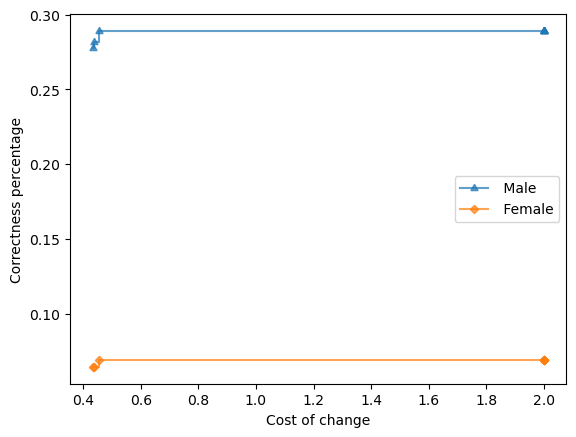

If Workclass =  Private, capital-loss = 0:
	Protected Subgroup ' Male', 74.06% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 26.22% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 26.57% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 27.35% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 27.35% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 27.35% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 27.35% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 27.35% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 27.35% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 76.84% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 6.23% and counterfactual 

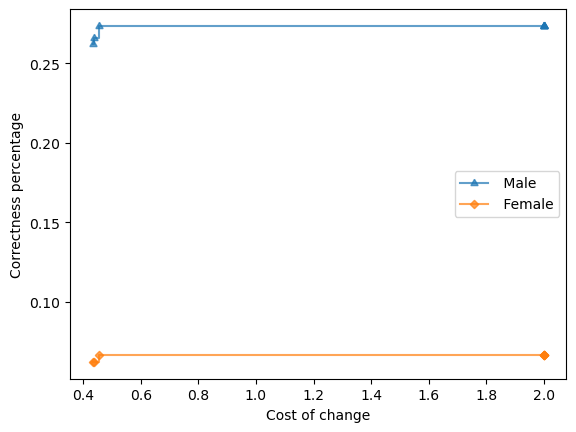

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 43.49% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 52.48% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.11% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 86.41% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 86.41% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 86.41% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 86.41% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 86.41% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 86.41% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 86.41% and counterfa

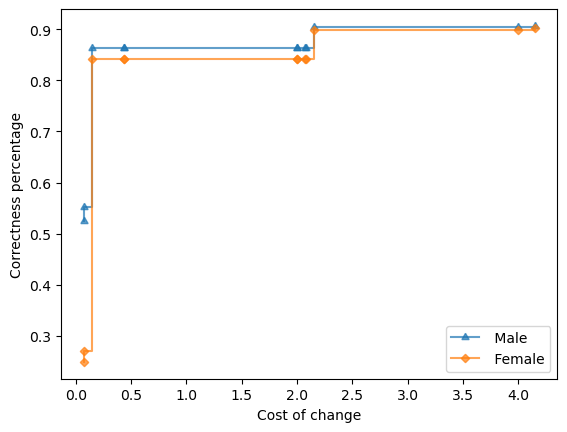

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 49.11% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 50.39% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 52.85% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 85.13% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 85.13% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 85.13% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 85.13% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 85.13% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 85.13% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 85.13% and counterfactual cost = 2.08.
		Make capital

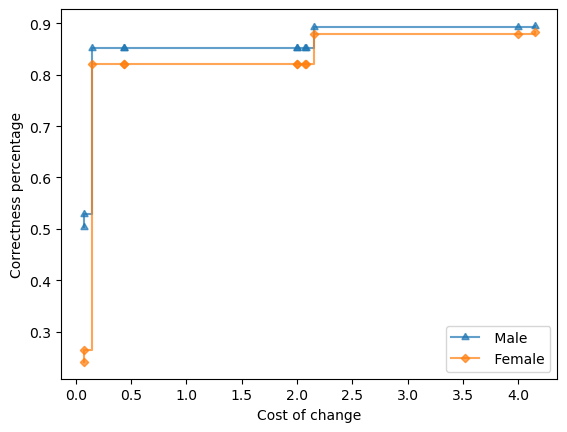

If capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 50.37% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 50.89% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.32% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 85.41% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 85.41% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 85.41% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 85.41% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 85.41% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.54% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 89.54% and counterfactual cost = 4.

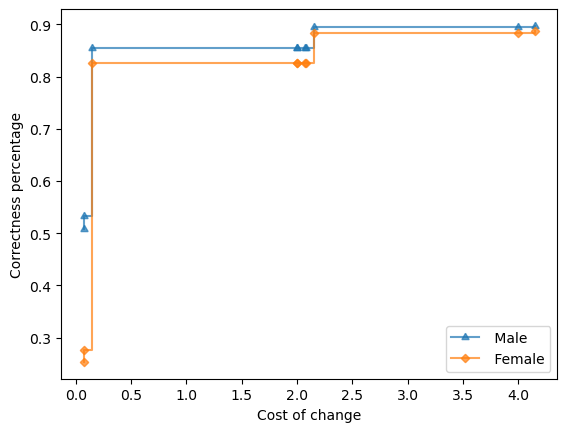

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 44.65% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 52.96% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.56% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 86.69% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 86.69% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 86.69% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 86.69% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 86.69% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 90.73% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 90

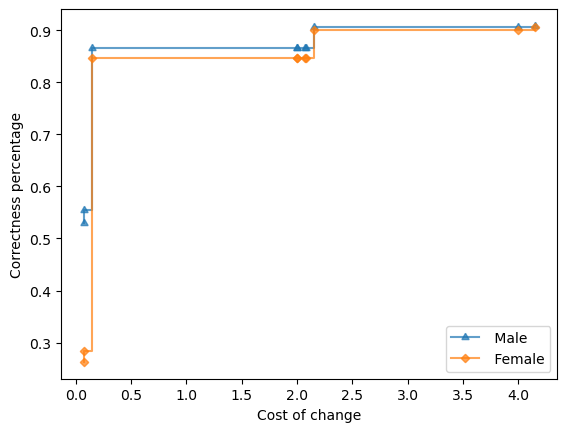

If Workclass =  Private, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 58.00% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.26% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 29.71% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 30.45% and counterfactual cost = 0.45.
		Make Workclass =  Self-emp-not-inc with effectiveness 30.45% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov with effectiveness 30.45% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 30.45% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 30.45% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 30.45% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 30.45% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 57.48

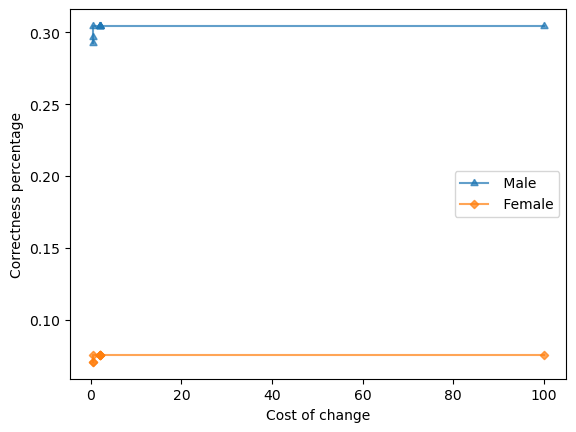

If Workclass =  Private, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 63.76% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 27.79% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 28.20% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 28.92% and counterfactual cost = 0.45.
		Make Workclass =  Self-emp-not-inc with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 28.92% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 28.92% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 28.92% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 28.92% and count

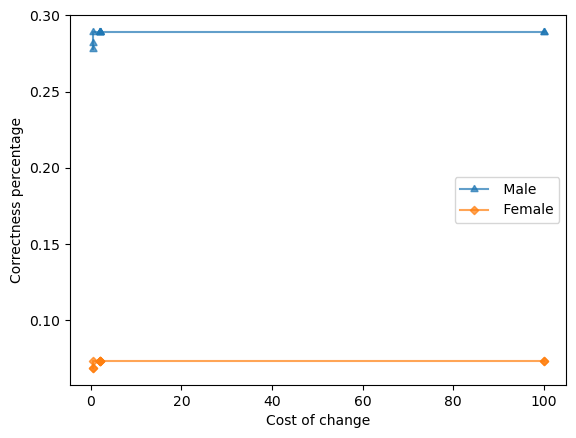

If Workclass =  Private, capital-gain = 0, capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 39.41% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 50.23% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 50.23% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 50.23% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 50.23% and counterfactual cost = 2.0.
		Make hours-per-week = MidTime with effectiveness 50.23% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 50.23% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 50.23% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 50.23% and counterfactual cost = 2.0.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 88.06% and counterfactual cost = 2.1

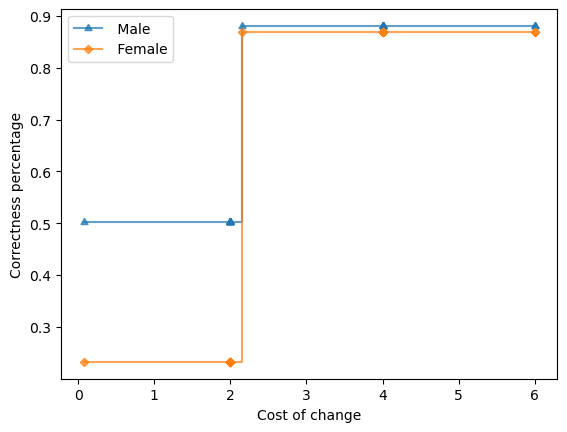

If Workclass =  Private, capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 40.45% covered (protected subgroup population size not given)
		Make capital-gain = 7688 with effectiveness 50.79% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 50.79% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 50.79% and counterfactual cost = 2.0.
		Make hours-per-week = MidTime with effectiveness 50.79% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 50.79% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 50.79% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 50.79% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 50.79% and counterfactual cost = 2.0.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 88.29% and counterfactual cost = 2.15.
		Make Workclas

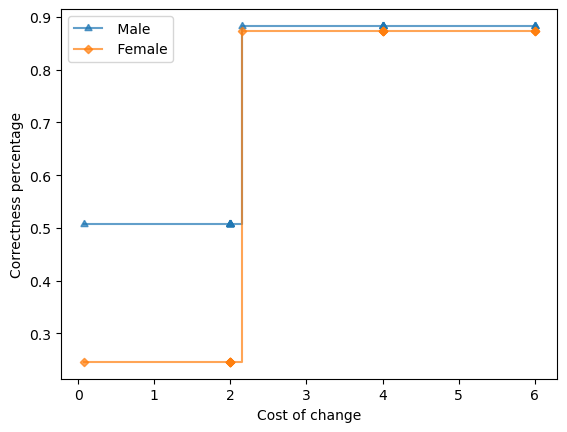

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 37.08% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 54.59% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 57.35% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.31% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 87.31% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 87.31% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.31% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.31% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.31% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverT

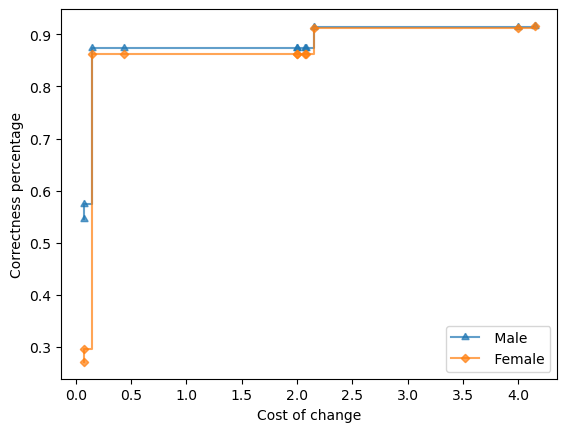

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 40.82% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 52.28% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.87% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 85.97% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 85.97% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 85.97% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 85.97% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 85.97% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 85.97% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 90.19% and

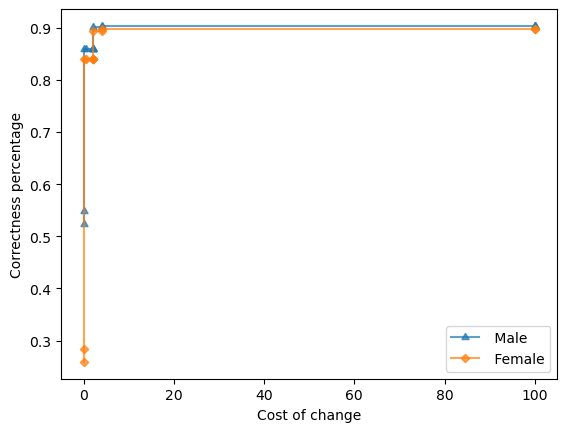

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 38.05% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 55.04% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 57.77% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.56% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 87.56% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.56% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.56% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.56% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 91.61% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with e

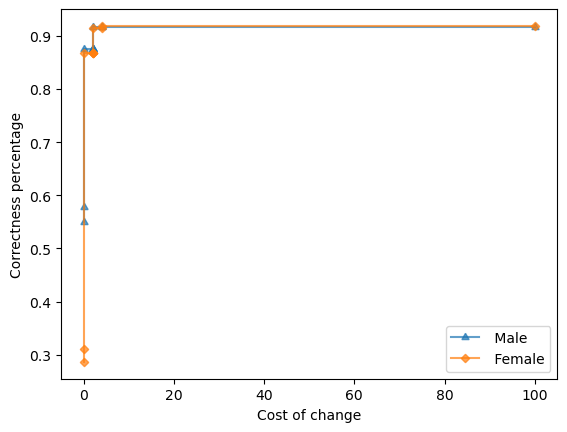

If capital-gain = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 41.84% covered (protected subgroup population size not given)
		Make capital-gain = 7298 with effectiveness 52.72% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.28% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 86.20% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 86.20% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 86.20% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 86.20% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 86.20% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 90.36% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 90.36% and counterfa

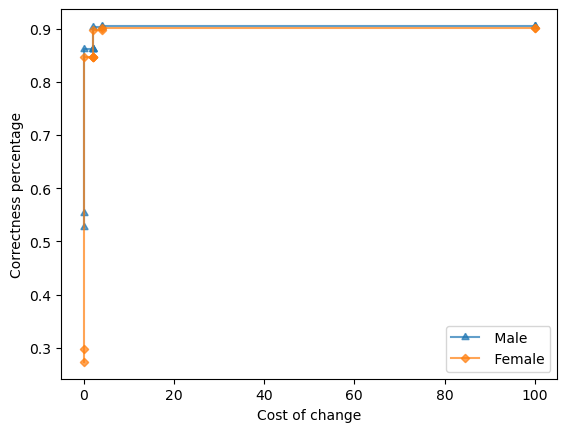

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 44.99% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.71% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 30.19% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 30.19% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 30.19% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 30.19% and counterfactual cost = 4.0.
	Protected Subgroup ' Female', 41.25% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 7.08% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 7.08% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 7.08% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with 

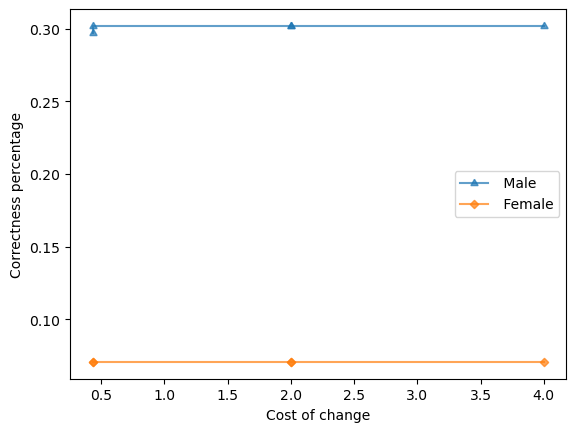

If capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 50.79% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 28.12% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 28.54% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 28.54% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 28.54% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 28.54% and counterfactual cost = 4.0.
	Protected Subgroup ' Female', 46.11% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 6.95% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 6.95% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 6.95% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 6.95% and counterfa

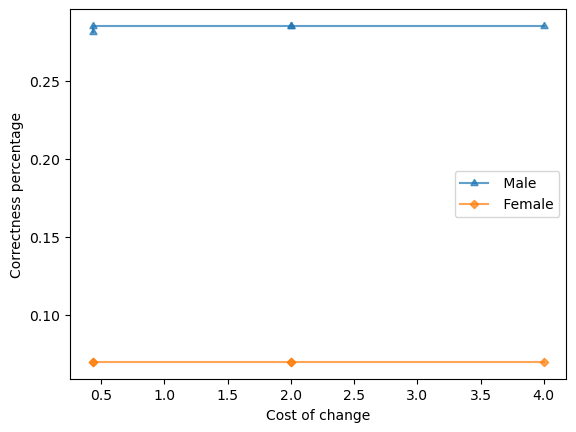

If age = (41.0, 50.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 14.70% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 74.84% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.34% and counterfactual cost = 10.15.
	Protected Subgroup ' Female', 15.51% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 38.73% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 91.36% and counterfactual cost = 10.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.11.
	Cumulative effectiveness plot for the above recourses:


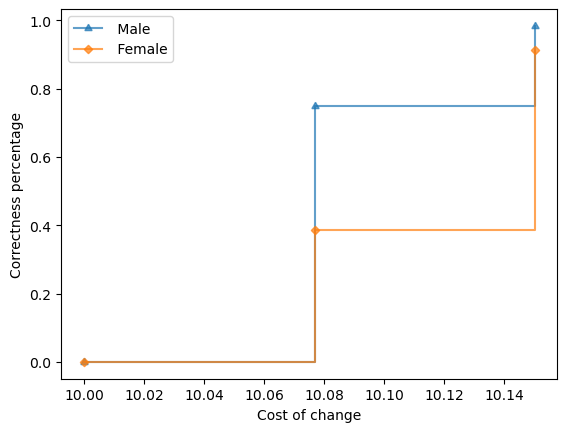

If age = (41.0, 50.0], capital-gain = 0:
	Protected Subgroup ' Male', 15.05% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 75.13% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.38% and counterfactual cost = 10.15.
	Protected Subgroup ' Female', 16.08% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 39.88% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 91.67% and counterfactual cost = 10.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.04.
	Cumulative effectiveness plot for the above recourses:


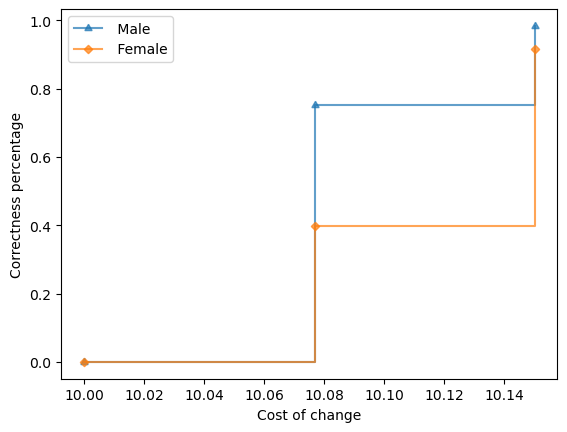

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 38.31% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 31.50% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 31.50% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 31.50% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 31.50% and counterfactual cost = 4.0.
		Make race =  Black with effectiveness 31.50% and counterfactual cost = 100.0.
		Make hours-per-week = OverTime, race =  Black with effectiveness 31.50% and counterfactual cost = 102.0.
	Protected Subgroup ' Female', 31.97% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 8.23% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 8.23% and counterfactual cost = 2.0.
		Mak

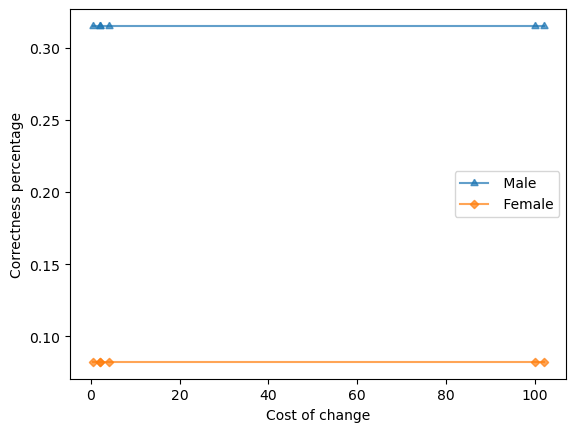

If capital-loss = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 42.15% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 29.97% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 29.97% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 29.97% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 29.97% and counterfactual cost = 4.0.
		Make race =  Asian-Pac-Islander with effectiveness 29.97% and counterfactual cost = 100.0.
		Make race =  Black with effectiveness 29.97% and counterfactual cost = 100.0.
		Make hours-per-week = OverTime, race =  Black with effectiveness 29.97% and counterfactual cost = 102.0.
	Protected Subgroup ' Female', 35.03% covered (protected subgroup population size not given)
		Make capital-loss = 1887 with effectiveness 7.99% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime w

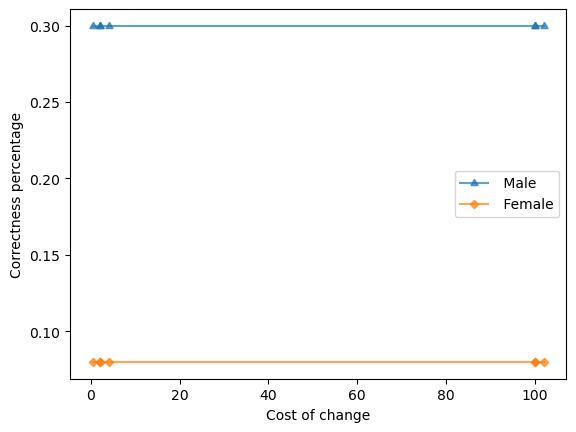

If age = (34.0, 41.0], capital-loss = 0:
	Protected Subgroup ' Male', 16.22% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 1.13% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 6.87% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 47.27% and counterfactual cost = 10.44.
	Protected Subgroup ' Female', 15.75% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.61% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 2.13% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 14.89% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.53.
	Cumulative effectiveness plot for the above recourses:


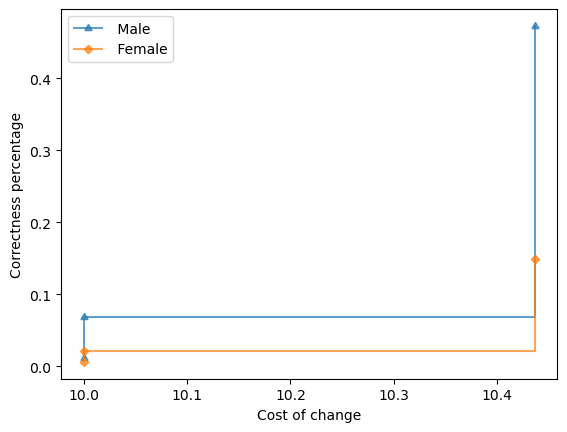

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 14.62% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 1.04% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 7.21% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 48.80% and counterfactual cost = 10.44.
	Protected Subgroup ' Female', 14.17% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.34% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 2.03% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 15.37% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.39.
	Cumulative effectiveness plot for the above recourses:


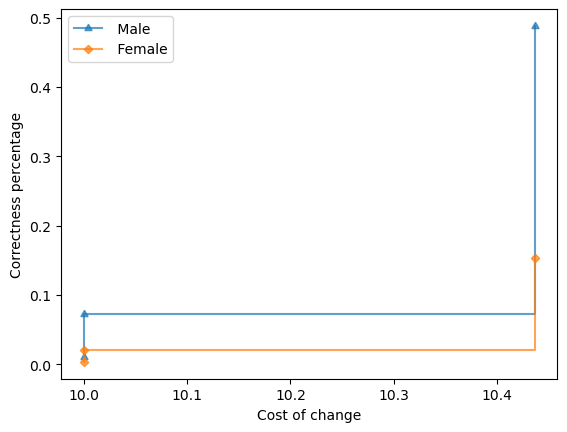

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 15.72% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 1.07% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 6.80% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 68.51% and counterfactual cost = 10.08.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 70.85% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 97.86% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 98.45% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 98.45% and counterfactual cost = 10.44.
	Protected Subgroup ' Female', 15.15% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.63% and coun

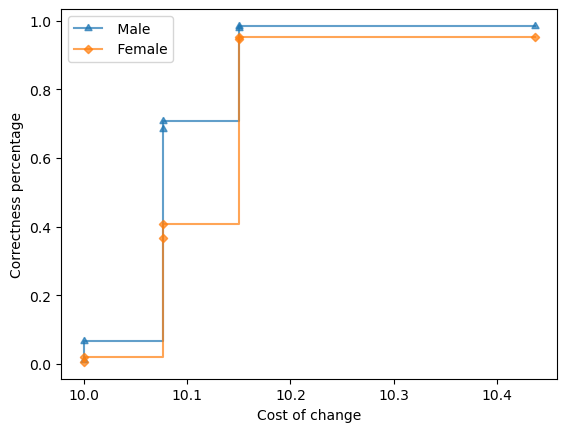

If age = (34.0, 41.0], capital-gain = 0:
	Protected Subgroup ' Male', 16.22% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 1.13% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 7.16% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 69.02% and counterfactual cost = 10.08.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 71.28% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 97.93% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 98.49% and counterfactual cost = 10.15.
	Protected Subgroup ' Female', 15.51% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.62% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 2.16% and counterfactual cost = 10.0.
		Make age = (50.

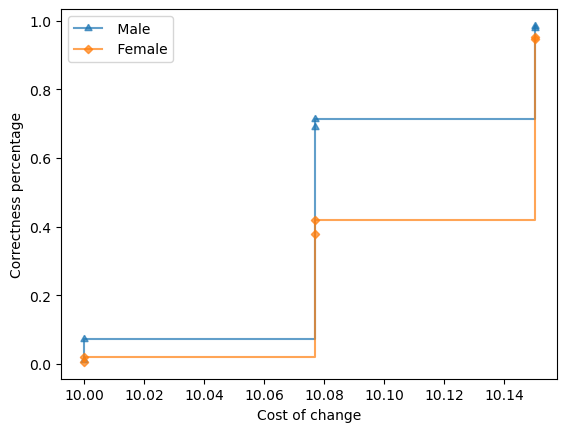

If age = (26.0, 34.0], capital-loss = 0:
	Protected Subgroup ' Male', 23.86% covered (protected subgroup population size not given)
		Make age = (34.0, 41.0] with effectiveness 8.96% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 13.51% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 42.45% and counterfactual cost = 10.44.
	Protected Subgroup ' Female', 19.65% covered (protected subgroup population size not given)
		Make age = (34.0, 41.0] with effectiveness 1.71% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 3.65% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 15.59% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.23.
	Cumulative effectiveness plot for the above recourses:


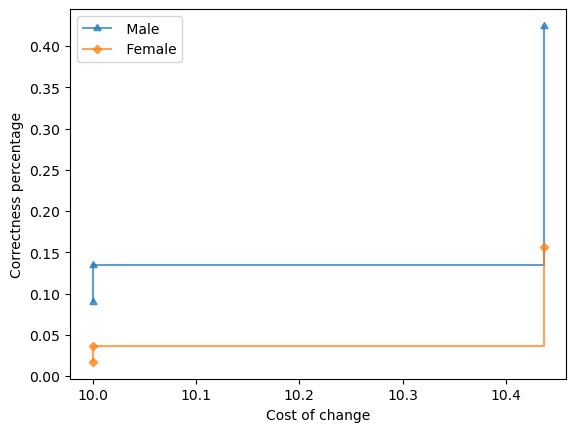

If age = (26.0, 34.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 21.26% covered (protected subgroup population size not given)
		Make age = (34.0, 41.0] with effectiveness 9.12% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 14.01% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 44.61% and counterfactual cost = 10.44.
	Protected Subgroup ' Female', 17.54% covered (protected subgroup population size not given)
		Make age = (34.0, 41.0] with effectiveness 1.64% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 3.82% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 16.37% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.19.
	Cumulative effectiveness plot for the above recourses:


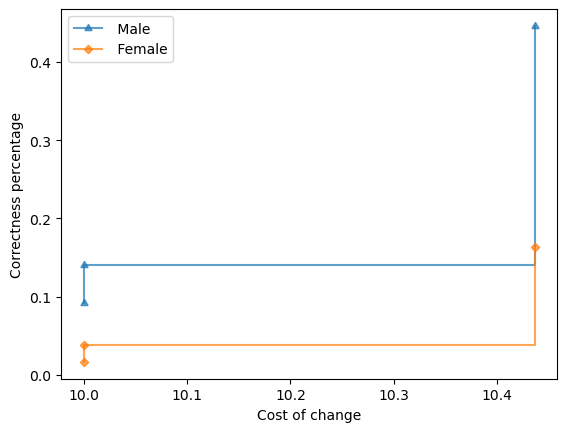

If capital-gain = 0, capital-loss = 0, occupation =  Sales:
	Protected Subgroup ' Male', 9.44% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 2.91% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 6.63% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 6.80% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 14.56% and counterfactual cost = 4.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with effectiveness 60.84% and counterfactual cost = 4.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with effectiveness 89.16% and counterfactual cost = 4.15.
		Make capital-gain = 15024, occupation =  Exec-managerial with effect

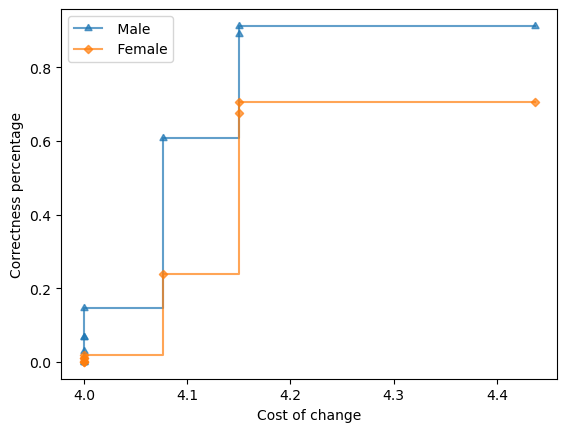

If capital-gain = 0, occupation =  Sales:
	Protected Subgroup ' Male', 9.73% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 2.98% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 6.75% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 6.91% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 14.44% and counterfactual cost = 4.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with effectiveness 61.38% and counterfactual cost = 4.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with effectiveness 89.48% and counterfactual cost = 

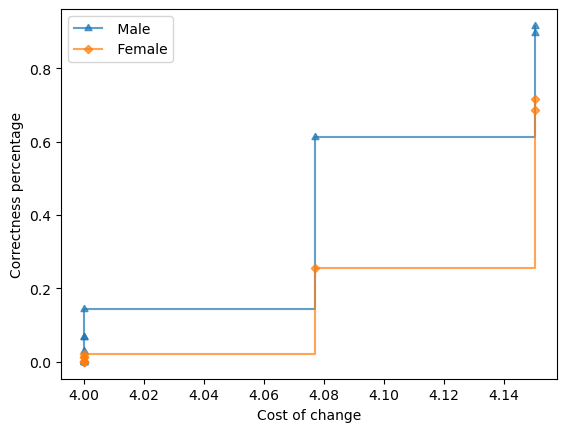

If capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 8.85% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 3.11% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 6.74% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 6.91% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 15.03% and counterfactual cost = 4.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with effectiveness 60.97% and counterfactual cost = 4.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with effectiveness 89.64% and counterfactual cost = 4.15.
		Make capital-gain = 15024, occupati

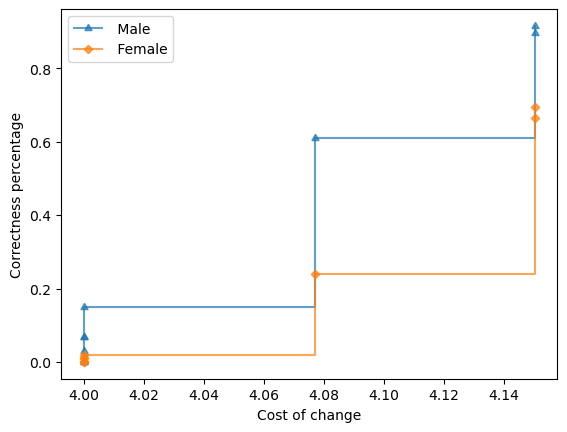

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 14.19% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.97% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 7.10% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 72.66% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.49% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 99.03% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 99.03% and counterfactual cost = 10.44.
	Protected Subgroup ' Female', 13.59% covered (protected subgroup population size not given)
		Make age = (50.0, 90.0] with effectiveness 0.35% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 1.94

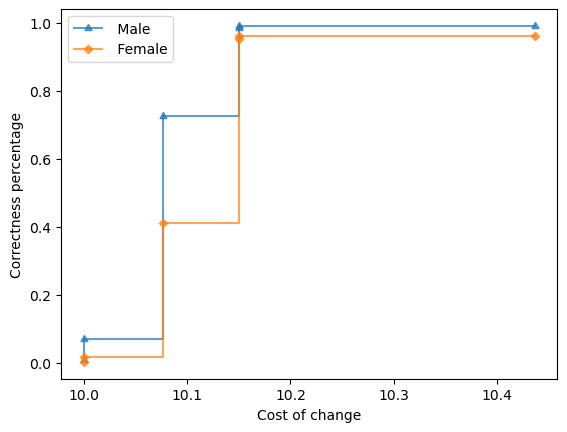

In [35]:
affected_pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)

In [36]:
end_time = time.time()

In [37]:
end_time - start_time

18.316589832305908

In [38]:
stats["metrics-time"] = end_time - start_time

In [40]:
stats

{'freq-itemsets-no': {' Female': 28176, ' Male': 27510},
 'inter-groups-no': 13300,
 'unaff-freq-itemsets-no': 57008,
 'valid-if-thens-time': 1237.2908010482788,
 'cumulative-time': 620.324743270874,
 'triples-no': 97413,
 'subgroup-no': 12556,
 'metrics-time': 18.316589832305908}

In [41]:
stats["valid-if-thens-time"] + stats["cumulative-time"] + stats["metrics-time"]

1875.9321341514587